In [1]:
HOME_FOLDER = "/content/drive/MyDrive/IISE DAIS Case Study Competition"
DATA_DIR = "Dataset"
OUTPUT_DIR = "outputs"

# Env setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install monai
!pip install pynrrd
!pip install morphsnakes

In [4]:
import numpy as np
import pandas as pd
import os
import torch
import random
from monai.metrics import DiceMetric, ConfusionMatrixMetric, MeanIoU

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [6]:
%load_ext autoreload
%autoreload 2
os.chdir(HOME_FOLDER)
os.chdir("utils")
from visualization import visualize_results, visualize_patient
from pipeline import model_pipeline
from inference import run_sequential_inference
from sliding_window import sliding_window_inference
os.chdir(HOME_FOLDER)

# Perform train test split

Create a random train test split of patients by providing a split ratio and a seed. In our experiments, we used seed = 2024 and test_patient_ratio=0.2.

In [ ]:
# preparare_train_test_txt(data_dir="Dataset", test_patient_ratio=0.2, seed=2024)

The patient HCC_017 is removed due to label issues including necrosis.
Total patients: 97
   There are 77 patients in training
   There are 20 patients in test
Files saved to train-test-split-seed1/train.txt and train-test-split-seed1/test.txt


# Model configurations

From our experiments on different preprocceesing, losses, and model architectures, we obtained the following best configurations for liver and tumor models

In [7]:
# SegResNetVAE with global view for liver segmentation
config_liver = dict(

    # inputs
    DATA_DIR = "Dataset",
    TRAIN_PATIENTS_FILE = 'train-test-split-seed2024/train.txt',
    TEST_PATIENTS_FILE = 'train-test-split-seed2024/test.txt',

    # data
    ROI_SIZE = (512,512,16),
    HU_RANGE = (-150,250),
    POSTPROCESSING_MORF = False,

    # training
    MAX_EPOCHS = 150,
    BATCH_SIZE = 1,
    LEARNING_RATE = 1e-4,
    LOSS = "fdice",                   # [gdice, cdice, dice, fdice, wfdice]

    # model
    TYPE = "liver",                   # liver, tumor
    MODEL_NAME = "3DSegResNetVAE",    # 3DUNet, 3DSegResNet,  3DUNetPlusPlus, 3DMANet, 2DUNet, 2DSegResNet, 2DUNetPlusPlus, 2DMANet.
    DROPOUT = 0.2,

    # efficiency
    NUM_WORKERS = 0,
    AUTOCAST = False                   # mixed precision, save memory
)


In [8]:
# SegResNetVAE with local view + morp post-processing + weak supervision for tumor segmentation
config_tumor = dict(

    # inputs
    DATA_DIR = "Dataset",
    TRAIN_PATIENTS_FILE = 'train-test-split-seed2024/train.txt',
    TEST_PATIENTS_FILE = 'train-test-split-seed2024/test.txt',

    # clinical
    CLINICAL_DATA_FILE = "Dataset/HCC-TACE-Seg_clinical_data-V2.xlsx",
    CLINICAL_PREDICTORS = ['T_involvment', 'CLIP_Score','Personal history of cancer', 'TNM', 'Metastasis','fhx_can', 'Alcohol', 'Smoking', 'Evidence_of_cirh', 'AFP', 'age', 'Diabetes', 'Lymphnodes', 'Interval_BL', 'TTP'],
    LAMBDA_WEAK = 0.6,

    # data
    ROI_SIZE = (256,256,32),
    HU_RANGE = (-200,250),
    MASKNONLIVER = True,                 # mask out the image outside liver and crop to a local view
    POSTPROCESSING_MORF = True,

    # training
    TRAIN = False,
    MAX_EPOCHS = 150,
    BATCH_SIZE = 1,
    LEARNING_RATE = 1e-4,
    LOSS = "wfdice",                     # [gdice, cdice, dice, fdice, wfdice]

    # model
    TYPE = "tumor",                      # liver, tumor
    MODEL_NAME = "3DSegResNetVAE",       # 3DUNet, 3DSegResNet, 3DUNetPlusPlus, 3DMANet, 2DUNet, 2DSegResNet, 2DUNetPlusPlus, 2DMANet.
    DROPOUT = 0.2,

    # efficiency
    NUM_WORKERS = 0,
    AUTOCAST = False                   # mixed precision, save memory
)

# Training

Before training, you can optionally launch the tensorboard to visualize loss convergence and track validation metrics and even images.

In [ ]:
# launche tensorboard for real-time tracking of training progress
# %load_ext tensorboard
# %tensorboard --logdir=runs

First, we train the liver segmentation model

In [ ]:
test_images, test_labels, test_outputs = model_pipeline(config=config_liver)

Next, we train the tumor segmentation model using ground truth liver masks

In [ ]:
test_images, test_labels, test_outputs = model_pipeline(config=config_tumor)

# Inference

In [9]:
eval_metrics = [
        ("sensitivity", ConfusionMatrixMetric(include_background=False, metric_name='sensitivity', reduction="mean_batch")),
        ("specificity", ConfusionMatrixMetric(include_background=False, metric_name='specificity', reduction="mean_batch")),
        ("accuracy", ConfusionMatrixMetric(include_background=False, metric_name='accuracy', reduction="mean_batch")),
        ("dice", DiceMetric(include_background=False, reduction="mean_batch")),
        ("IoU", MeanIoU(include_background=False, reduction="mean_batch"))
]

## Best model

We load the saved weights of the two best models to perform inference on test data

In [10]:
config_liver['PRETRAINED_WEIGHTS'] = 'liver_3DSegResNetVAE'
config_tumor['PRETRAINED_WEIGHTS'] = 'tumor_3DSegResNetVAE_weak_morp'


Loading models....
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 512, 512, 16]             432
         Dropout3d-2     [-1, 16, 512, 512, 16]               0
          Identity-3     [-1, 16, 512, 512, 16]               0
    InstanceNorm3d-4     [-1, 16, 512, 512, 16]               0
              ReLU-5     [-1, 16, 512, 512, 16]               0
            Conv3d-6     [-1, 16, 512, 512, 16]           6,912
    InstanceNorm3d-7     [-1, 16, 512, 512, 16]               0
              ReLU-8     [-1, 16, 512, 512, 16]               0
            Conv3d-9     [-1, 16, 512, 512, 16]           6,912
         ResBlock-10     [-1, 16, 512, 512, 16]               0
           Conv3d-11      [-1, 32, 256, 256, 8]          13,824
   InstanceNorm3d-12      [-1, 32, 256, 256, 8]               0
             ReLU-13      [-1, 32, 256, 256, 8]               0
           Conv3d-1

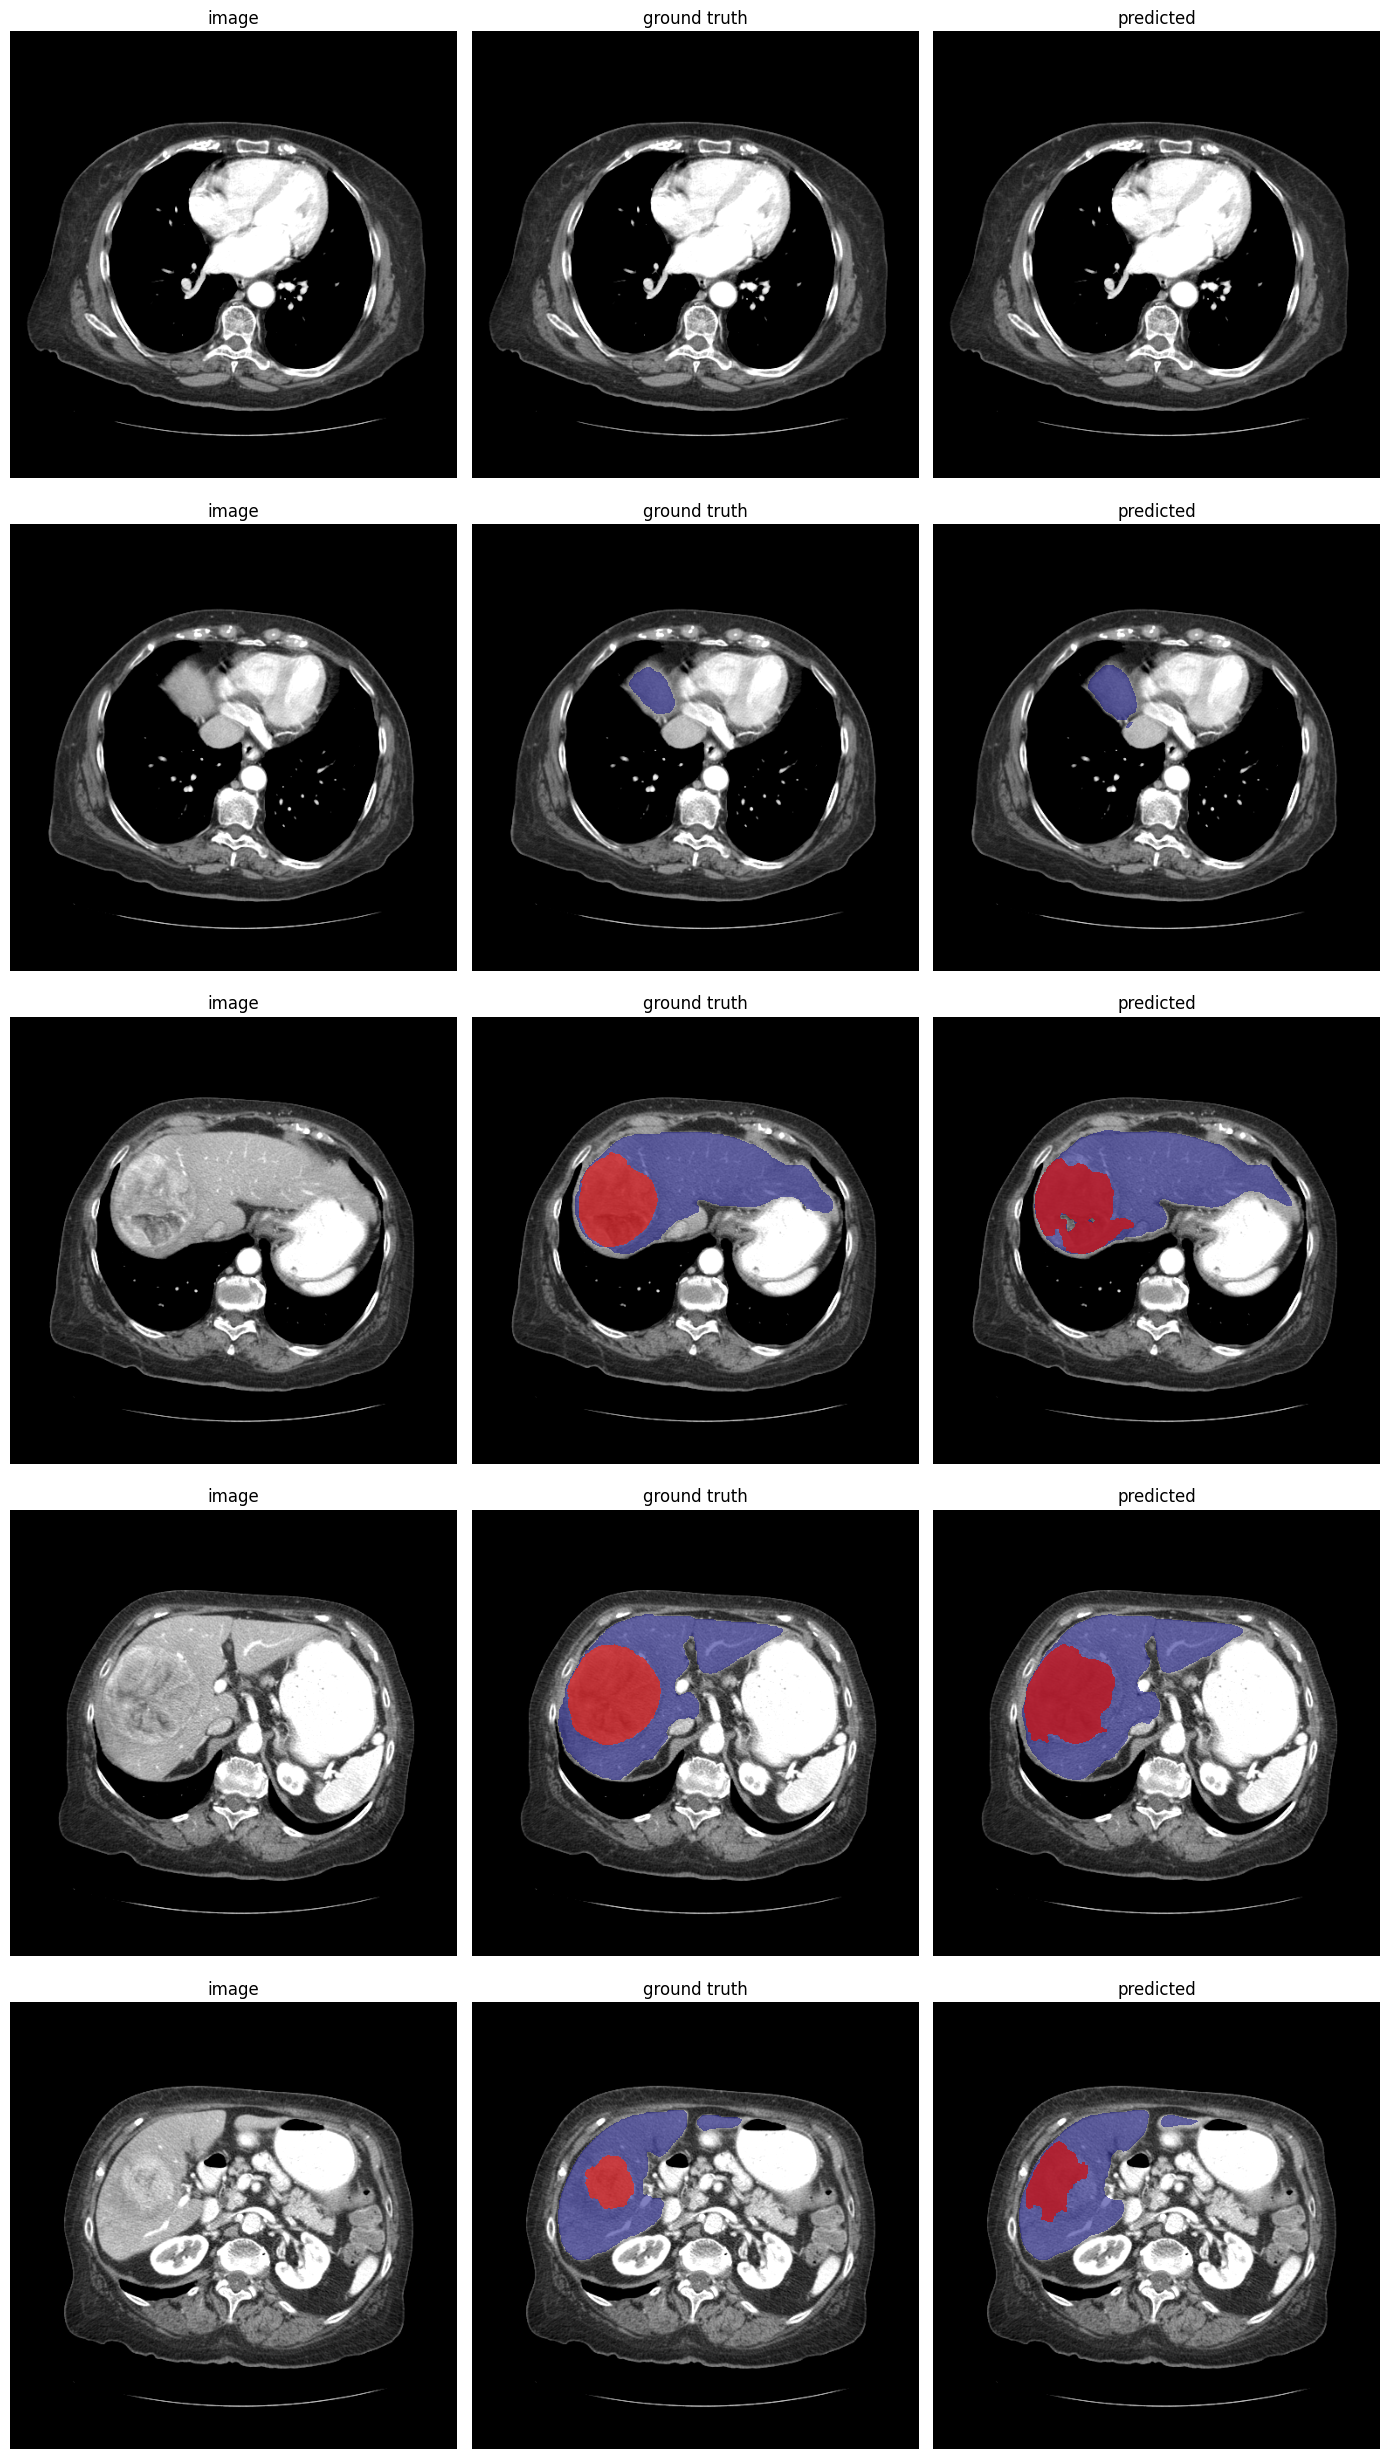

In [ ]:
run_sequential_inference('train-test-split-seed2024/test.txt', config_liver, config_tumor, eval_metrics, OUTPUT_DIR)

## Benchmarks

You Are Running on a: cuda
file name: tumor_3DSegResNetVAE_fdice_batchsize1_DAFalse_HU-150-250__512_512_16_dropout0.1_pretraining_evalnobackground
   There are 86 image-masks in this dataset.
   There are 23 image-masks in this dataset.
   Training patients: 68  Validation patients: 18
   Test patients: 23
Example data transformations:
  image shape: torch.Size([1, 512, 512, 16])
  mask shape: torch.Size([3, 512, 512, 16])
  mask values: [0. 1.]
  image min max: (0.0, 1.0)


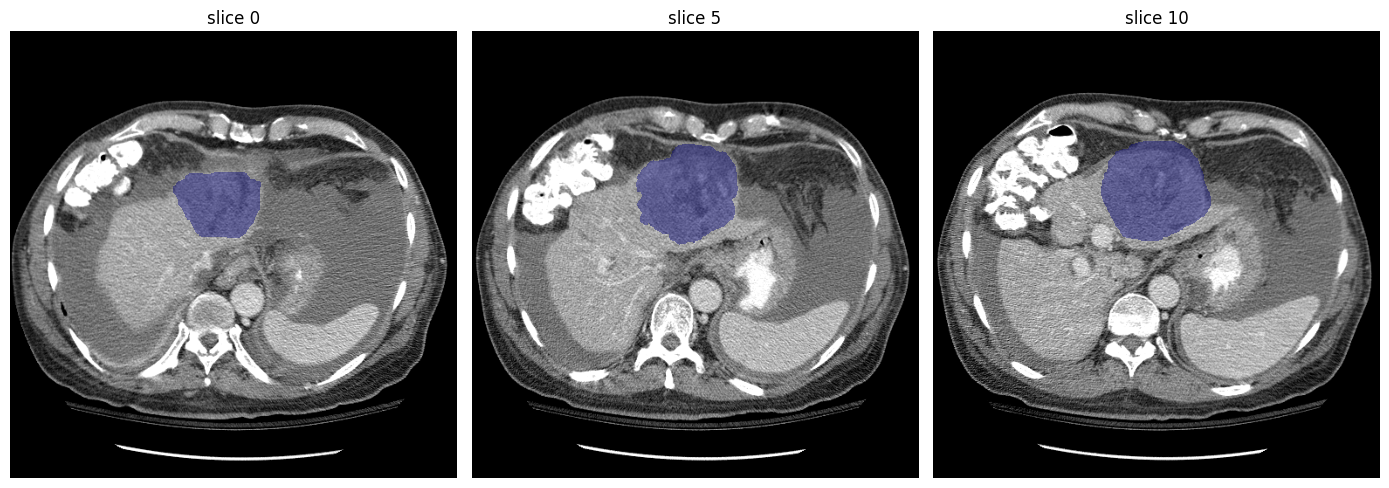

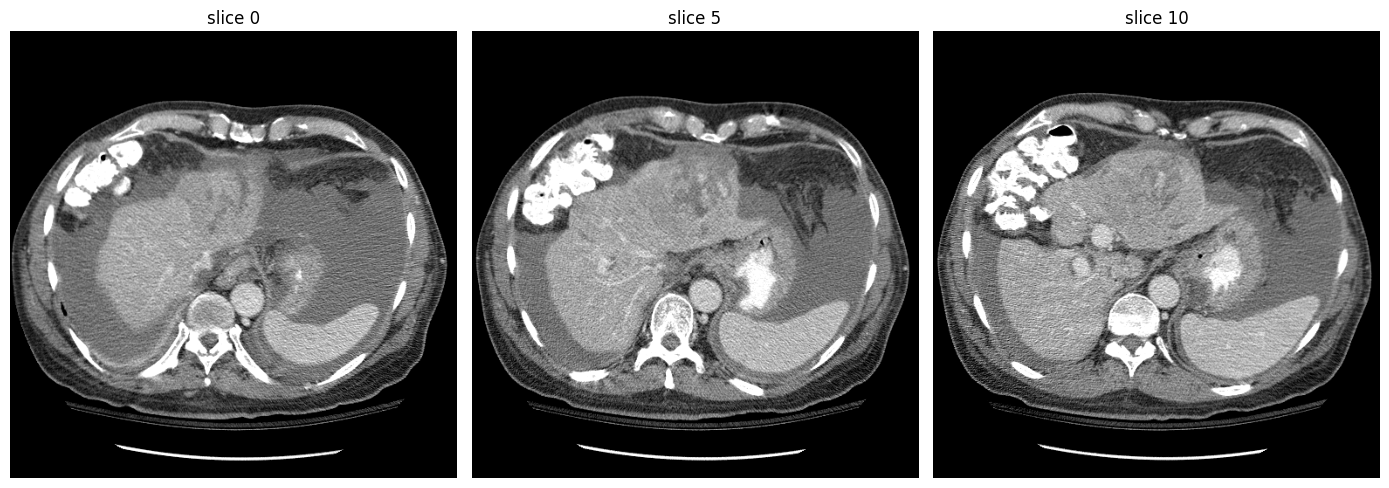

Test loader shapes: torch.Size([1, 1, 512, 512, 62]) torch.Size([1, 3, 512, 512, 62])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 512, 512, 16]             432
         Dropout3d-2     [-1, 16, 512, 512, 16]               0
          Identity-3     [-1, 16, 512, 512, 16]               0
    InstanceNorm3d-4     [-1, 16, 512, 512, 16]               0
              ReLU-5     [-1, 16, 512, 512, 16]               0
            Conv3d-6     [-1, 16, 512, 512, 16]           6,912
    InstanceNorm3d-7     [-1, 16, 512, 512, 16]               0
              ReLU-8     [-1, 16, 512, 512, 16]               0
            Conv3d-9     [-1, 16, 512, 512, 16]           6,912
         ResBlock-10     [-1, 16, 512, 512, 16]               0
           Conv3d-11      [-1, 32, 256, 256, 8]          13,824
   InstanceNorm3d-12      [-1, 32, 256, 256, 8]               0
             ReLU

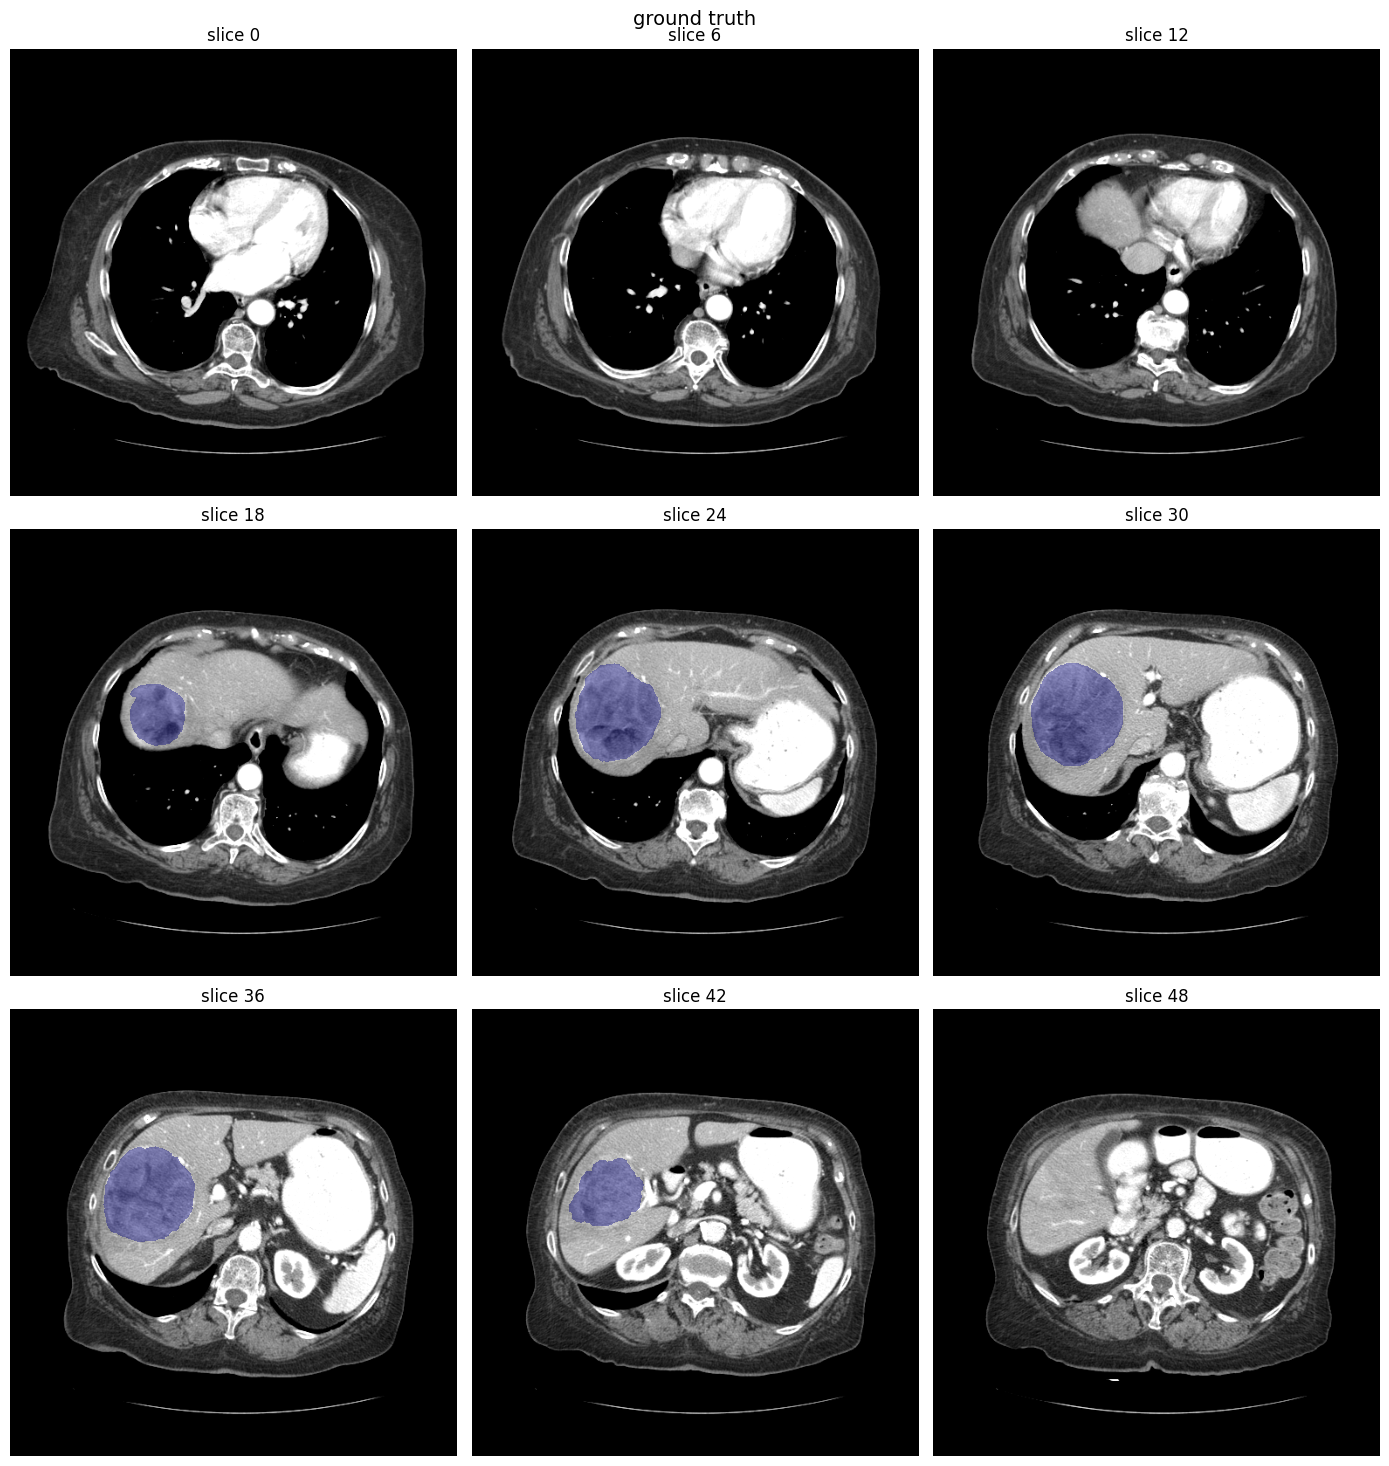

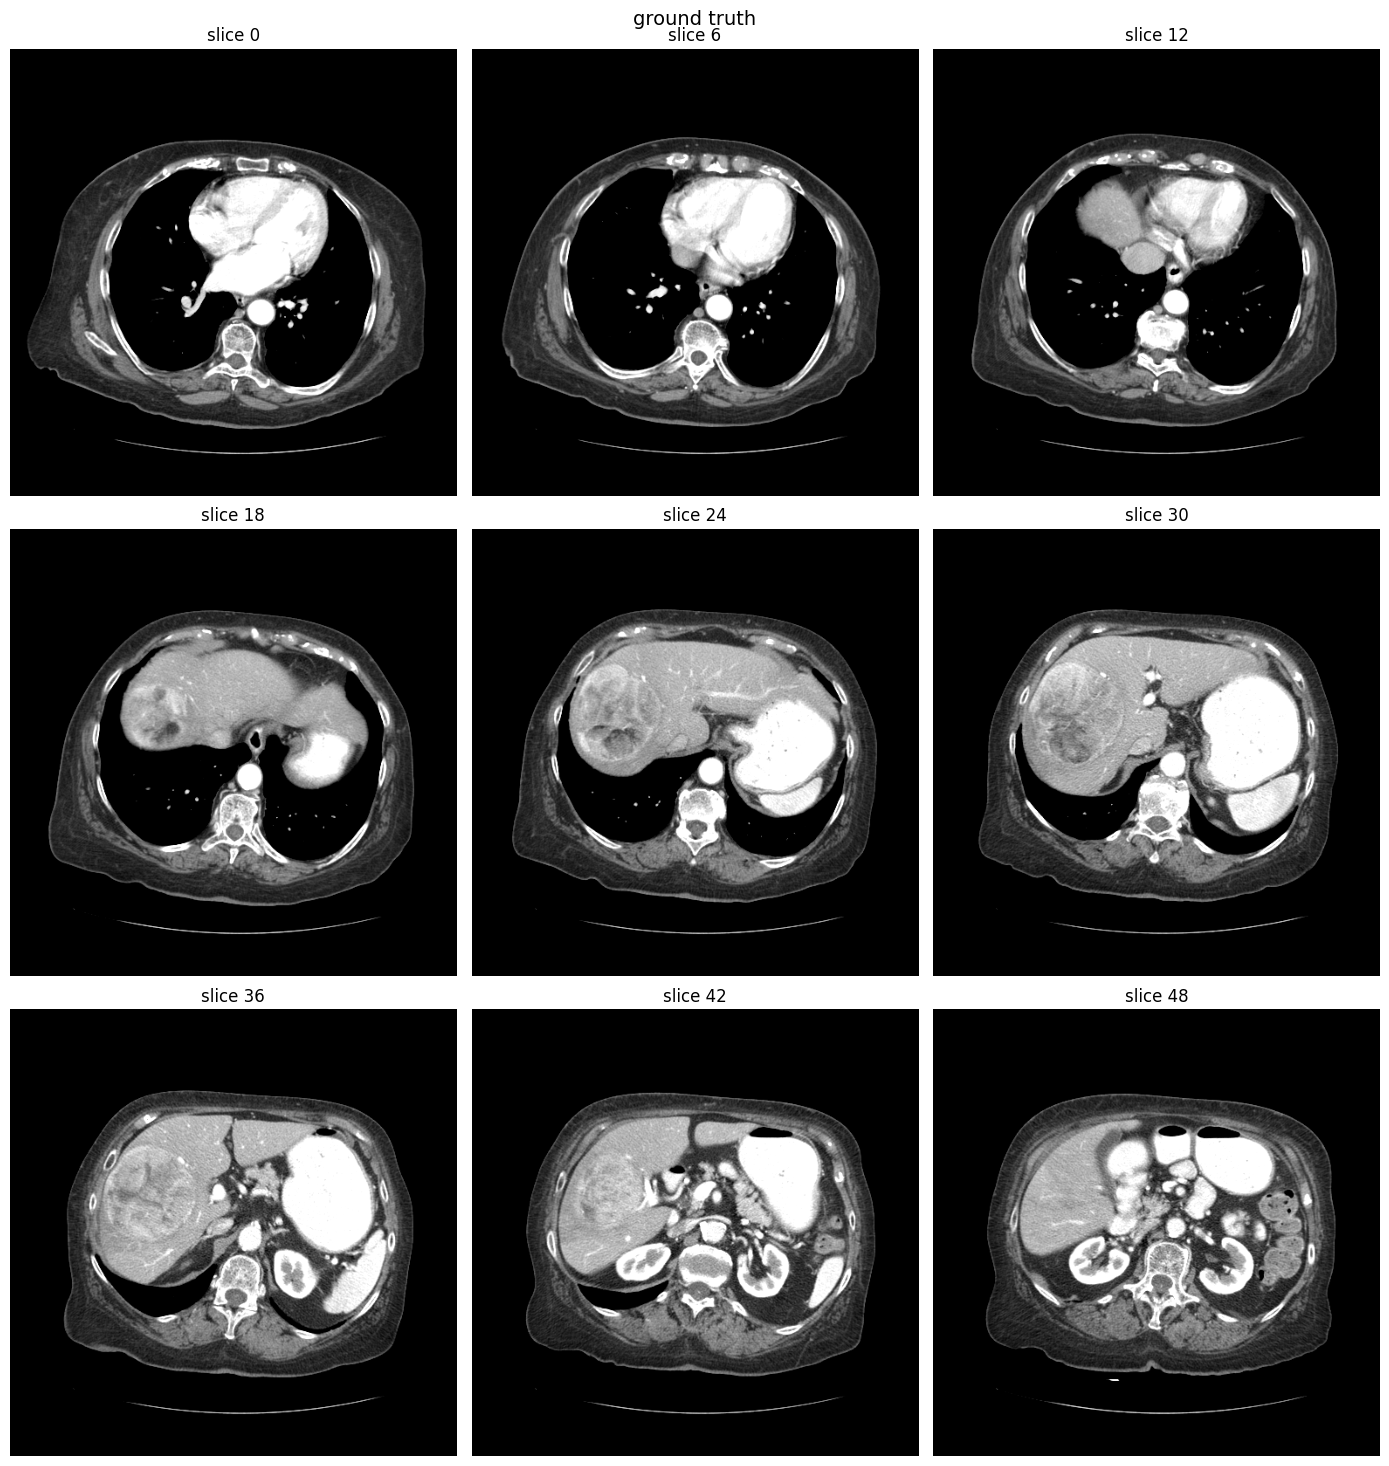

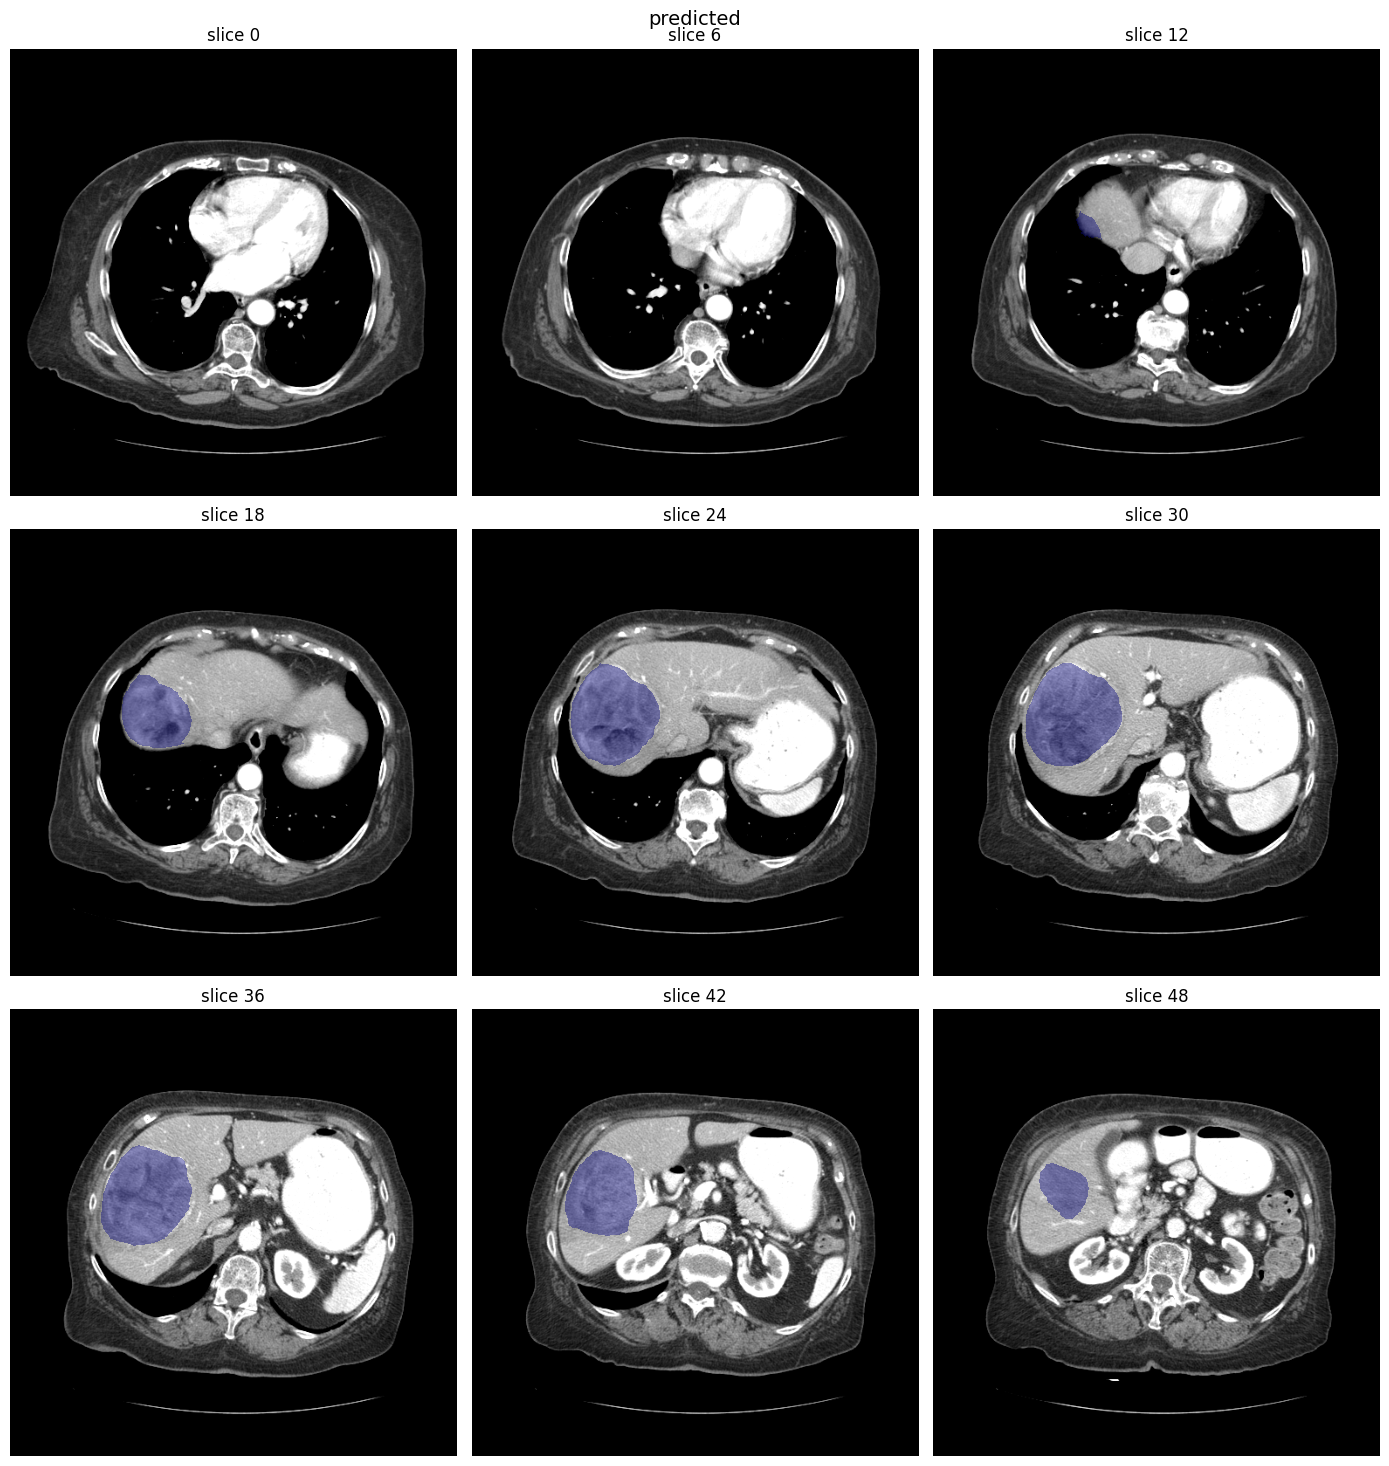

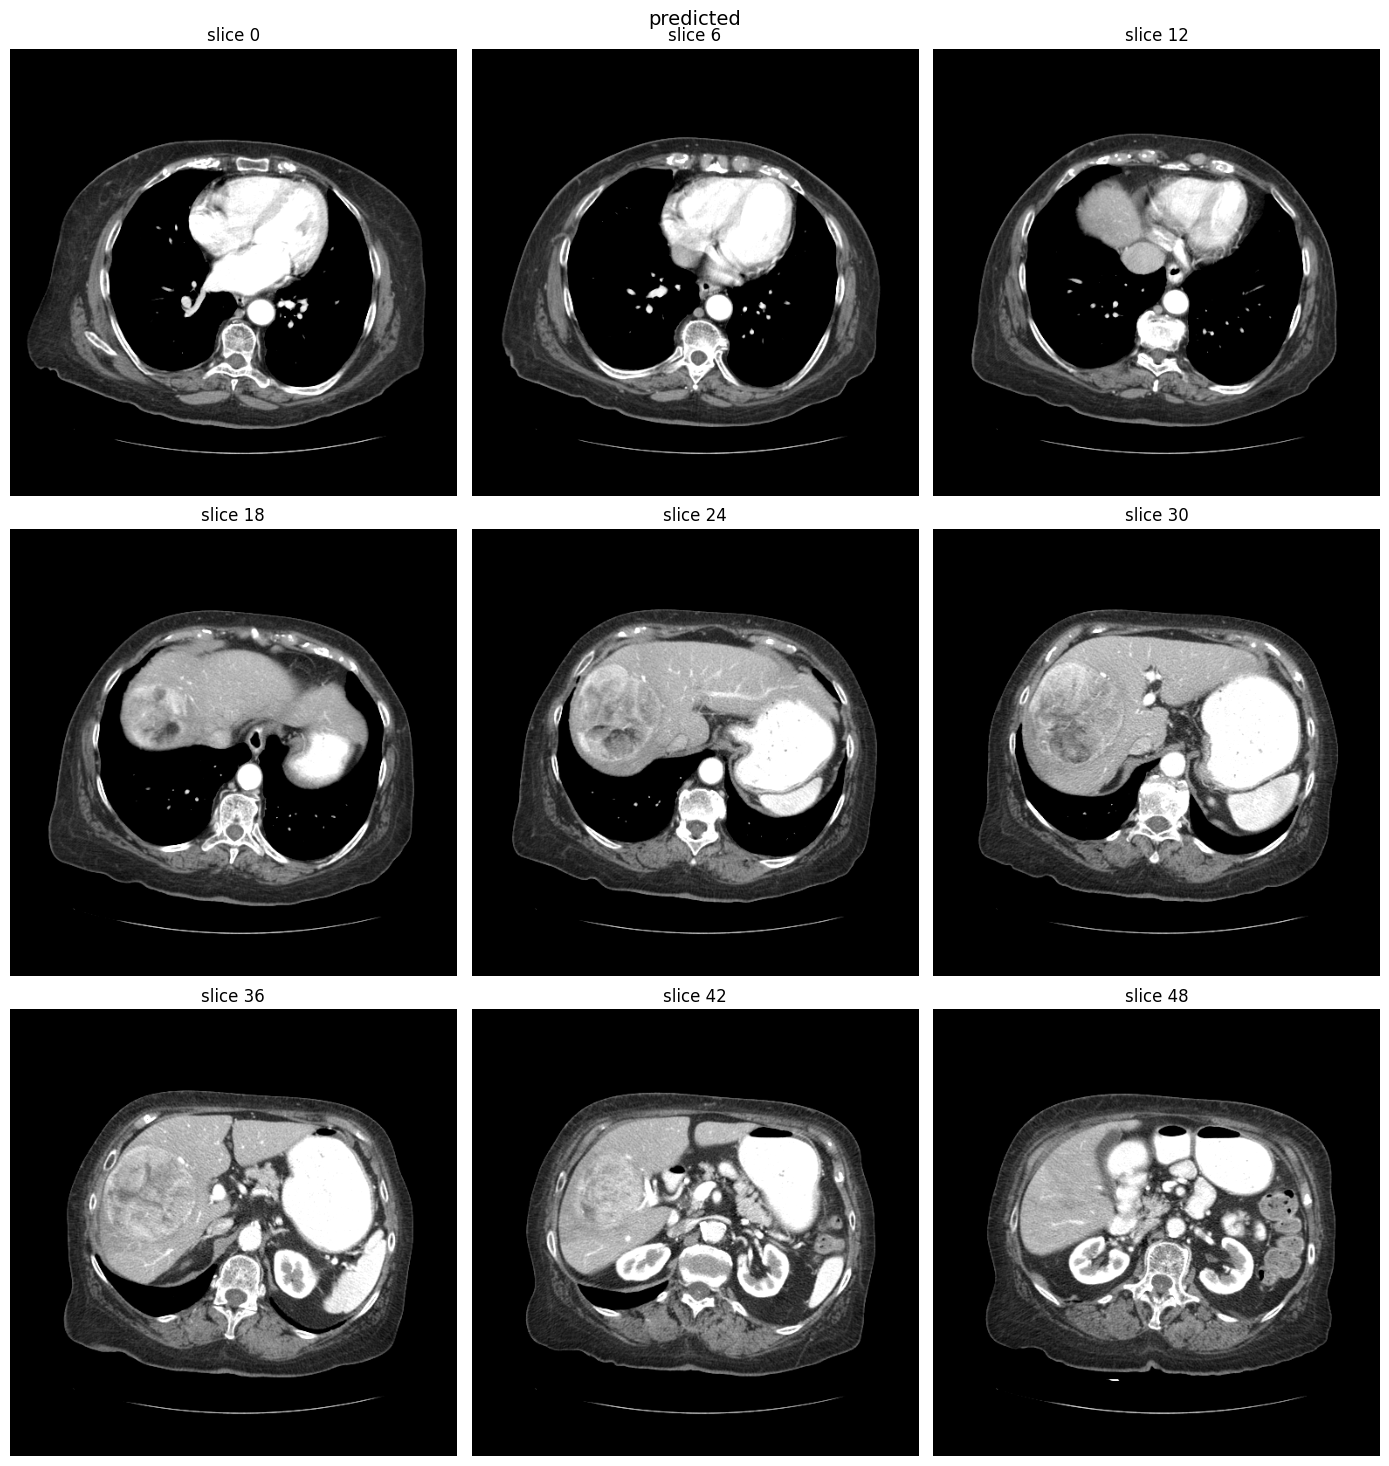

In [ ]:
# Multi-class SegresnetVAE
config_tumor = dict(

    # inputs
    DATA_DIR = "Dataset",
    TRAIN_PATIENTS_FILE = 'train-test-split-seed2024/train.txt',
    TEST_PATIENTS_FILE = 'train-test-split-seed2024/test.txt',

    # data preprocessing
    ROI_SIZE = (512,512,16),
    HU_RANGE = (-150,250),
    MASKNONLIVER = False,
    PREPROCESSING = "",
    POSTPROCESSING_MORF = False,

    # training
    TRAIN = False,
    MAX_EPOCHS = 150,
    BATCH_SIZE = 1,
    LEARNING_RATE = 1e-4,
    LOSS = "fdice",                    # [gdice, cdice, dice, fdice, wfdice]

    # model
    TYPE = "tumor",                   # liver, tumor
    MODEL_NAME = "3DSegResNetVAE",       # 3DUNet, 3DSegResNet, 3DUNetPlusPlus, 3DMANet, 2DUNet, 2DSegResNet, 2DUNetPlusPlus, 2DMANet.
    DROPOUT = 0.2,
    PRETRAINED_WEIGHTS = 'tumor_multiclass_3DSegResNetVAE',

    # efficiency
    NUM_WORKERS = 0,
    AUTOCAST = False                   # mixed precision, save memory
)
_ = model_pipeline(config_tumor)


Loading models....
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 512, 512, 16]             432
         Dropout3d-2     [-1, 16, 512, 512, 16]               0
          Identity-3     [-1, 16, 512, 512, 16]               0
    InstanceNorm3d-4     [-1, 16, 512, 512, 16]               0
              ReLU-5     [-1, 16, 512, 512, 16]               0
            Conv3d-6     [-1, 16, 512, 512, 16]           6,912
    InstanceNorm3d-7     [-1, 16, 512, 512, 16]               0
              ReLU-8     [-1, 16, 512, 512, 16]               0
            Conv3d-9     [-1, 16, 512, 512, 16]           6,912
         ResBlock-10     [-1, 16, 512, 512, 16]               0
           Conv3d-11      [-1, 32, 256, 256, 8]          13,824
   InstanceNorm3d-12      [-1, 32, 256, 256, 8]               0
             ReLU-13      [-1, 32, 256, 256, 8]               0
           Conv3d-1

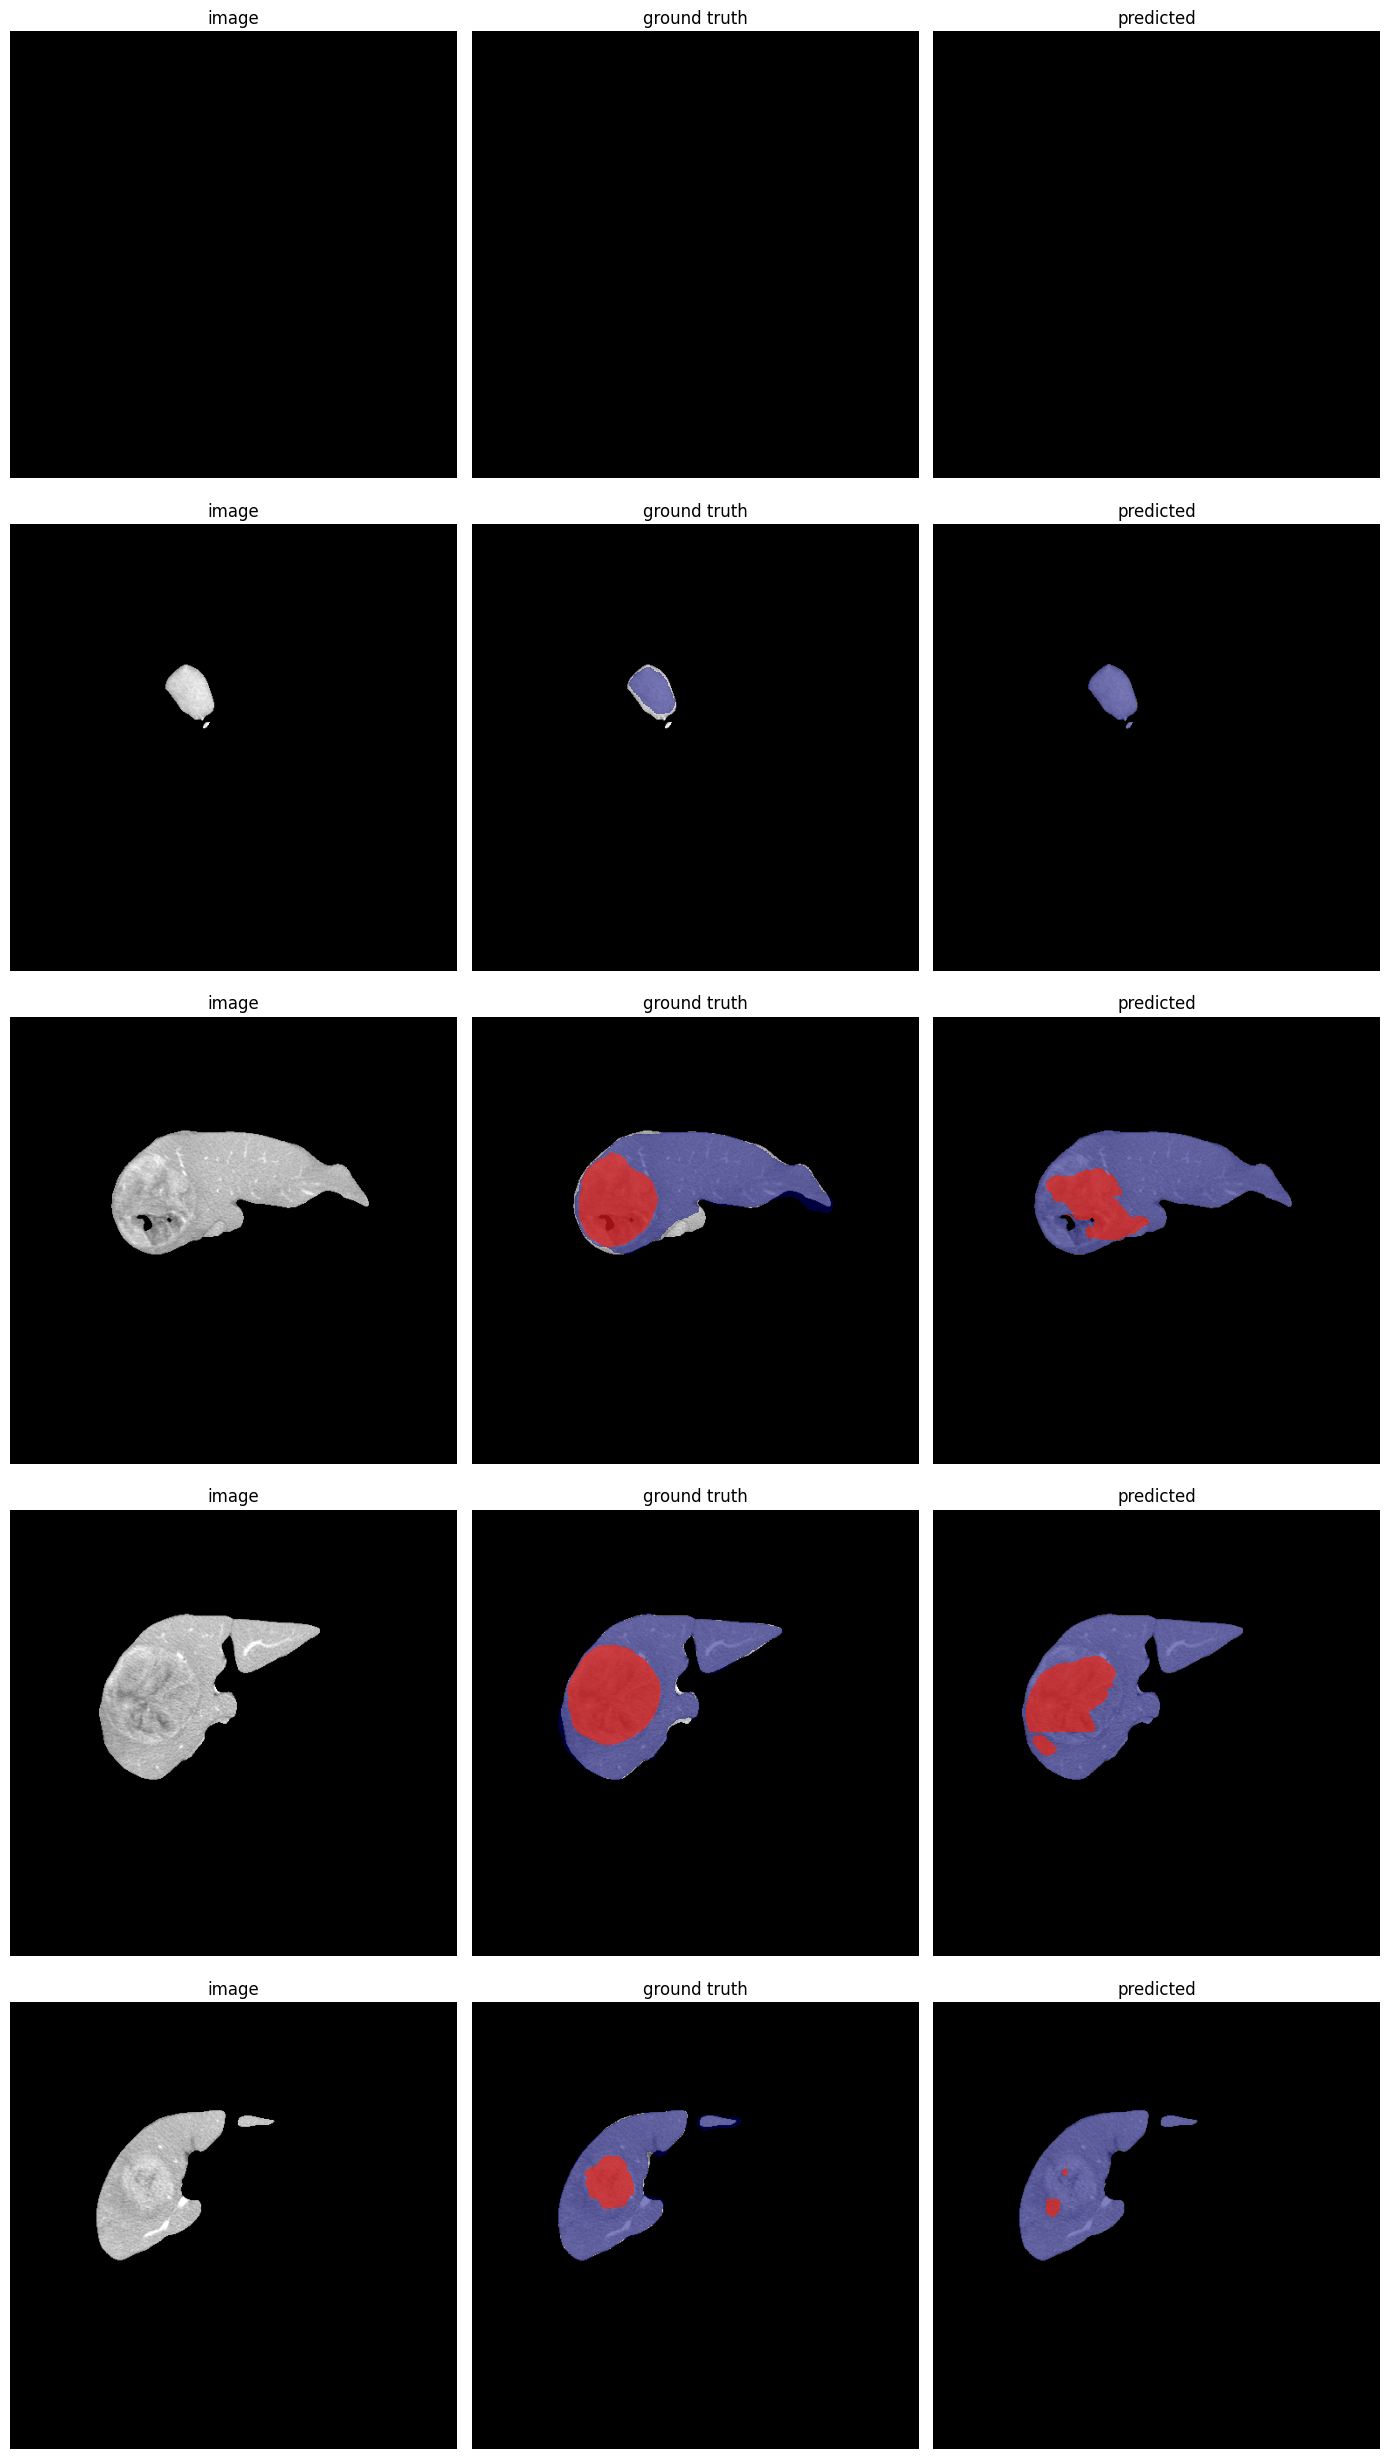

In [12]:
# SegResNetVAE with local view
config_tumor = dict(

    # inputs
    DATA_DIR = "Dataset",
    TRAIN_PATIENTS_FILE = 'train-test-split-seed2024/train.txt',
    TEST_PATIENTS_FILE = 'train-test-split-seed2024/test.txt',

    # clinical
    CLINICAL_DATA_FILE = "Dataset/HCC-TACE-Seg_clinical_data-V2.xlsx",
    CLINICAL_PREDICTORS = ['T_involvment', 'CLIP_Score','Personal history of cancer', 'TNM', 'Metastasis','fhx_can', 'Alcohol', 'Smoking', 'Evidence_of_cirh', 'AFP', 'age', 'Diabetes', 'Lymphnodes', 'Interval_BL', 'TTP'],
    LAMBDA_WEAK = 0.6,

    # data
    ROI_SIZE = (256,256,32),
    HU_RANGE = (-200,250),
    MASKNONLIVER = True,                 # mask out the image outside liver and crop to a local view
    POSTPROCESSING_MORF = False,

    # training
    TRAIN = False,
    MAX_EPOCHS = 150,
    BATCH_SIZE = 1,
    LEARNING_RATE = 1e-4,
    LOSS = "fdice",                     # [gdice, cdice, dice, fdice, wfdice]

    # model
    TYPE = "tumor",                      # liver, tumor
    MODEL_NAME = "3DSegResNetVAE",       # 3DUNet, 3DSegResNet, 3DUNetPlusPlus, 3DMANet, 2DUNet, 2DSegResNet, 2DUNetPlusPlus, 2DMANet.
    DROPOUT = 0.2,
    PRETRAINED_WEIGHTS = 'tumor_3DSegResNetVAE',

    # efficiency
    NUM_WORKERS = 0,
    AUTOCAST = False                   # mixed precision, save memory
)
run_sequential_inference('train-test-split-seed2024/test.txt', config_liver, config_tumor, eval_metrics, OUTPUT_DIR, only_tumor=True, export=False)


Loading models....
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 512, 512, 16]             432
         Dropout3d-2     [-1, 16, 512, 512, 16]               0
          Identity-3     [-1, 16, 512, 512, 16]               0
    InstanceNorm3d-4     [-1, 16, 512, 512, 16]               0
              ReLU-5     [-1, 16, 512, 512, 16]               0
            Conv3d-6     [-1, 16, 512, 512, 16]           6,912
    InstanceNorm3d-7     [-1, 16, 512, 512, 16]               0
              ReLU-8     [-1, 16, 512, 512, 16]               0
            Conv3d-9     [-1, 16, 512, 512, 16]           6,912
         ResBlock-10     [-1, 16, 512, 512, 16]               0
           Conv3d-11      [-1, 32, 256, 256, 8]          13,824
   InstanceNorm3d-12      [-1, 32, 256, 256, 8]               0
             ReLU-13      [-1, 32, 256, 256, 8]               0
           Conv3d-1

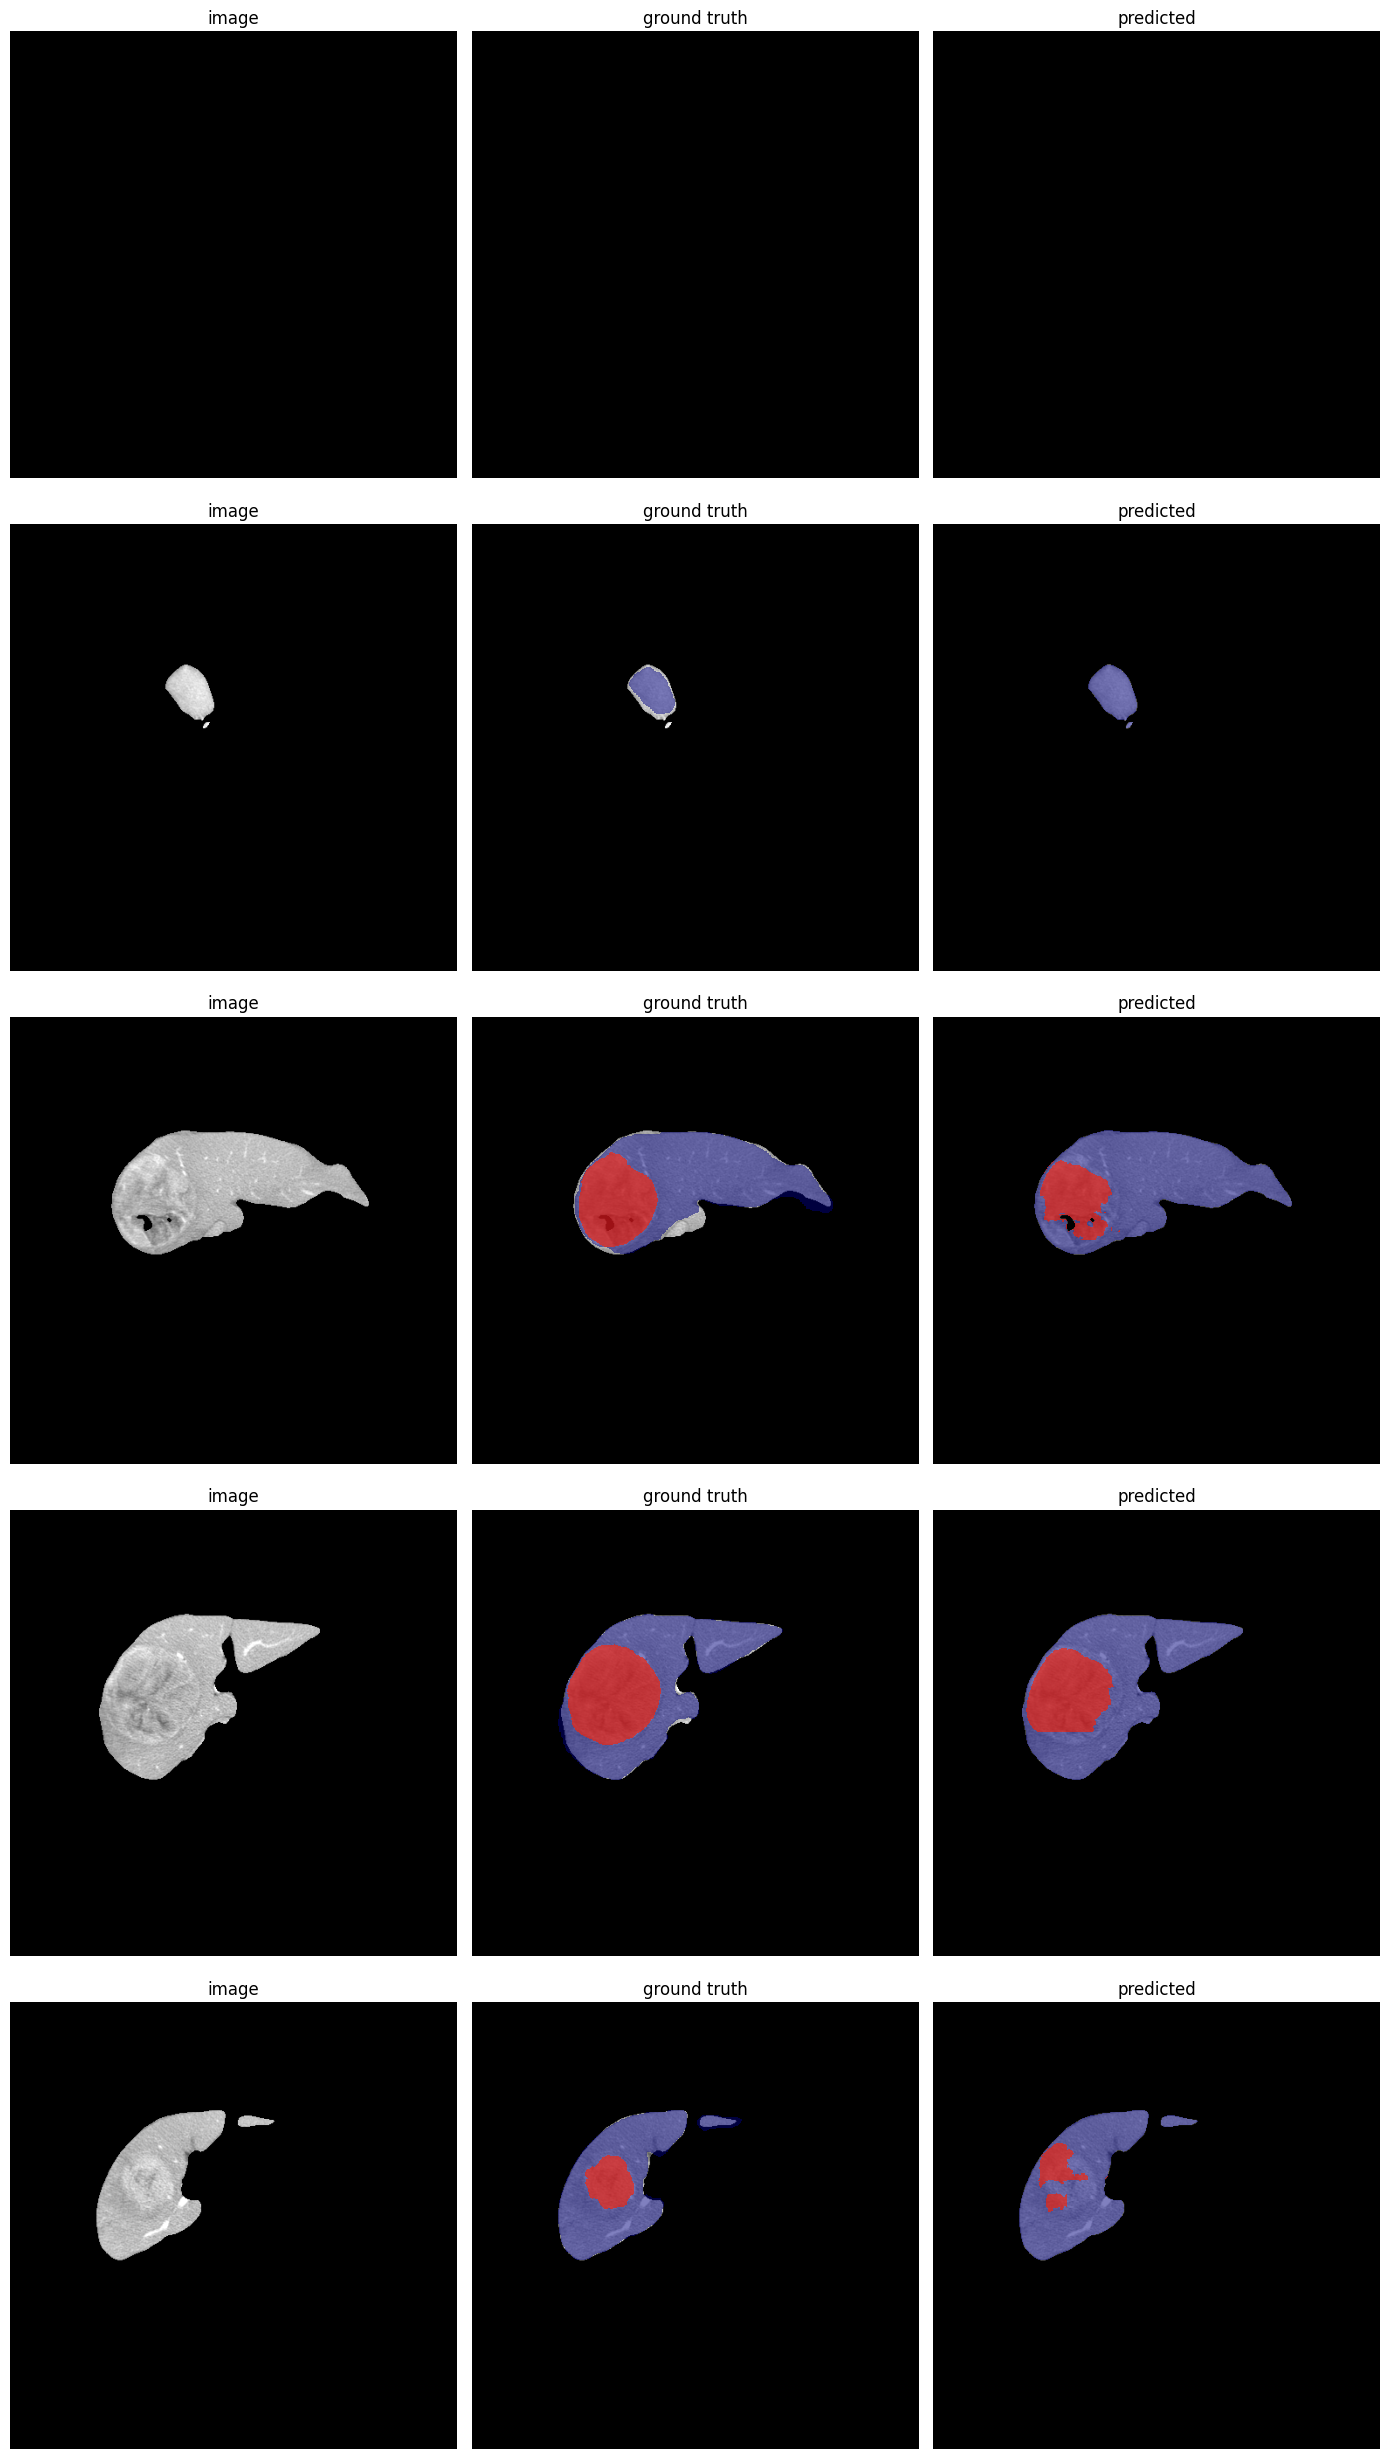

In [11]:
# SegResNetVAE with local view + weak
config_tumor = dict(

    # inputs
    DATA_DIR = "Dataset",
    TRAIN_PATIENTS_FILE = 'train-test-split-seed2024/train.txt',
    TEST_PATIENTS_FILE = 'train-test-split-seed2024/test.txt',

    # clinical
    CLINICAL_DATA_FILE = "Dataset/HCC-TACE-Seg_clinical_data-V2.xlsx",
    CLINICAL_PREDICTORS = ['T_involvment', 'CLIP_Score','Personal history of cancer', 'TNM', 'Metastasis','fhx_can', 'Alcohol', 'Smoking', 'Evidence_of_cirh', 'AFP', 'age', 'Diabetes', 'Lymphnodes', 'Interval_BL', 'TTP'],
    LAMBDA_WEAK = 0.5,

    # data
    ROI_SIZE = (256,256,32),
    HU_RANGE = (-200,250),
    MASKNONLIVER = True,                 # mask out the image outside liver and crop to a local view
    POSTPROCESSING_MORF = False,

    # training
    TRAIN = False,
    MAX_EPOCHS = 150,
    BATCH_SIZE = 1,
    LEARNING_RATE = 1e-4,
    LOSS = "wfdice",                     # [gdice, cdice, dice, fdice, wfdice]

    # model
    TYPE = "tumor",                      # liver, tumor
    MODEL_NAME = "3DSegResNet",       # 3DUNet, 3DSegResNet, 3DUNetPlusPlus, 3DMANet, 2DUNet, 2DSegResNet, 2DUNetPlusPlus, 2DMANet.
    DROPOUT = 0.2,
    PRETRAINED_WEIGHTS = 'tumor_3DSegResNetVAE_weak',

    # efficiency
    NUM_WORKERS = 0,
    AUTOCAST = False                   # mixed precision, save memory
)
run_sequential_inference('train-test-split-seed2024/test.txt', config_liver, config_tumor, eval_metrics, OUTPUT_DIR, only_tumor=True, export=False)


Loading models....
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 512, 512, 16]             432
         Dropout3d-2     [-1, 16, 512, 512, 16]               0
          Identity-3     [-1, 16, 512, 512, 16]               0
    InstanceNorm3d-4     [-1, 16, 512, 512, 16]               0
              ReLU-5     [-1, 16, 512, 512, 16]               0
            Conv3d-6     [-1, 16, 512, 512, 16]           6,912
    InstanceNorm3d-7     [-1, 16, 512, 512, 16]               0
              ReLU-8     [-1, 16, 512, 512, 16]               0
            Conv3d-9     [-1, 16, 512, 512, 16]           6,912
         ResBlock-10     [-1, 16, 512, 512, 16]               0
           Conv3d-11      [-1, 32, 256, 256, 8]          13,824
   InstanceNorm3d-12      [-1, 32, 256, 256, 8]               0
             ReLU-13      [-1, 32, 256, 256, 8]               0
           Conv3d-1

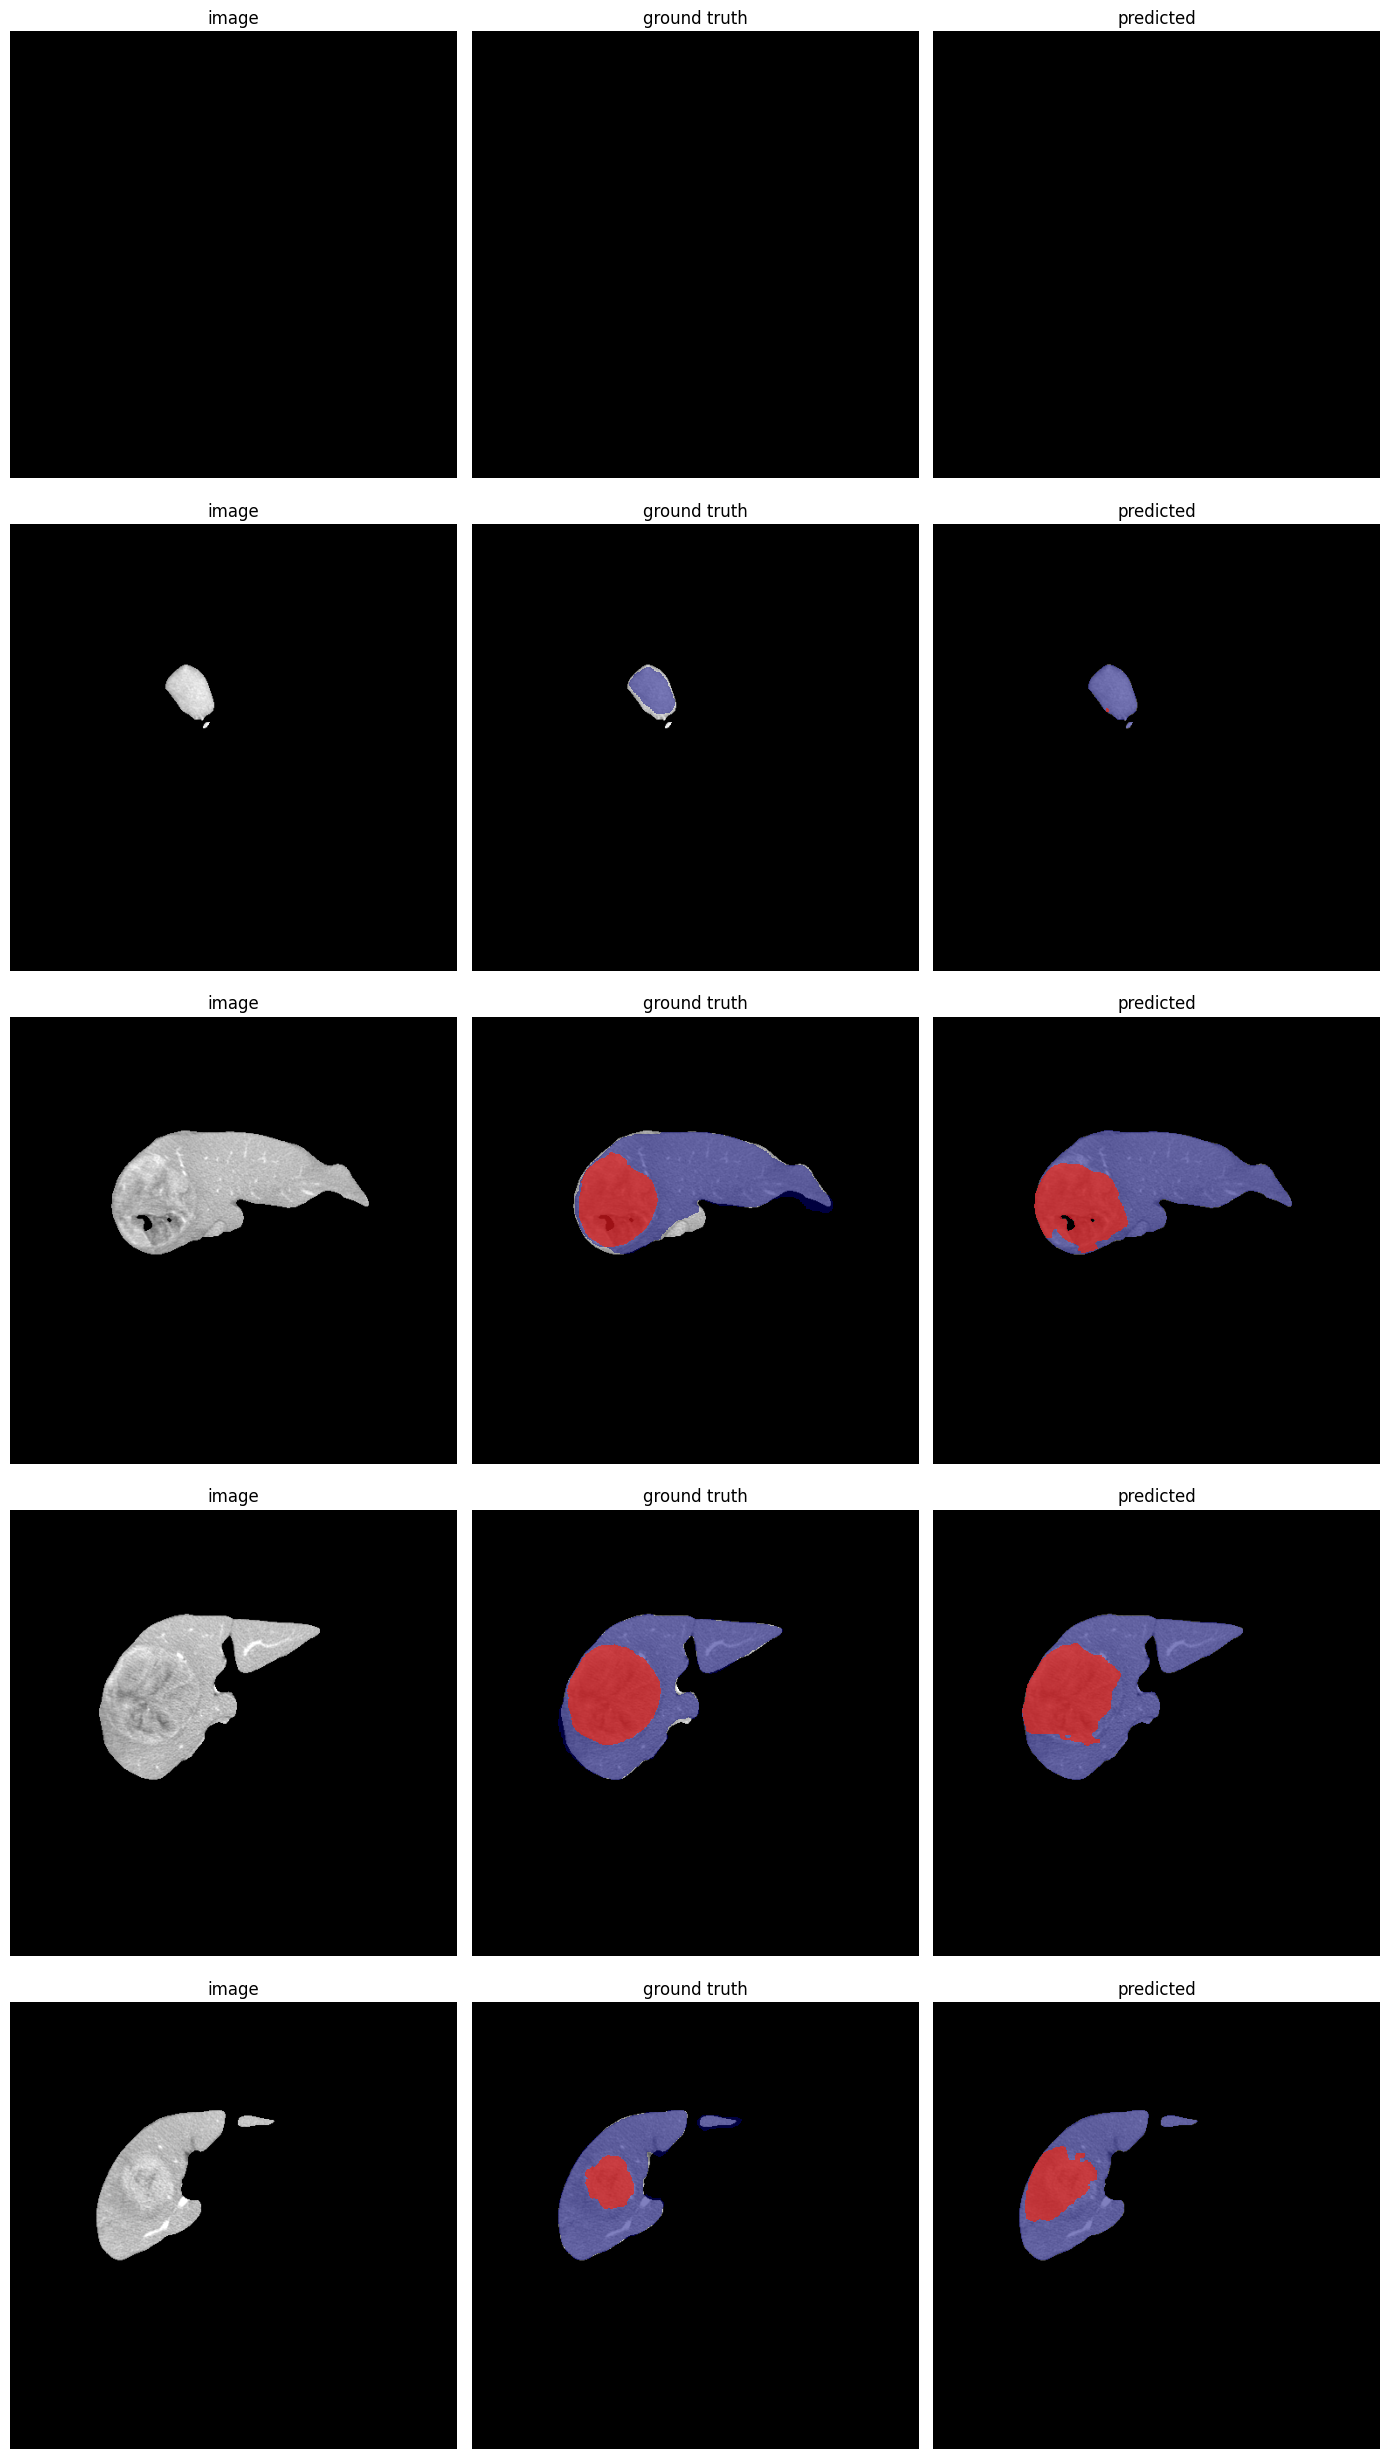

In [13]:
# SegResNetVAE with local view + morp
config_tumor = dict(

    # inputs
    DATA_DIR = "Dataset",
    TRAIN_PATIENTS_FILE = 'train-test-split-seed2024/train.txt',
    TEST_PATIENTS_FILE = 'train-test-split-seed2024/test.txt',

    # clinical
    CLINICAL_DATA_FILE = "Dataset/HCC-TACE-Seg_clinical_data-V2.xlsx",
    CLINICAL_PREDICTORS = ['T_involvment', 'CLIP_Score','Personal history of cancer', 'TNM', 'Metastasis','fhx_can', 'Alcohol', 'Smoking', 'Evidence_of_cirh', 'AFP', 'age', 'Diabetes', 'Lymphnodes', 'Interval_BL', 'TTP'],
    LAMBDA_WEAK = 0.6,

    # data
    ROI_SIZE = (256,256,32),
    HU_RANGE = (-200,250),
    MASKNONLIVER = True,                 # mask out the image outside liver and crop to a local view
    POSTPROCESSING_MORF = True,

    # training
    TRAIN = False,
    MAX_EPOCHS = 150,
    BATCH_SIZE = 1,
    LEARNING_RATE = 1e-4,
    LOSS = "fdice",                     # [gdice, cdice, dice, fdice, wfdice]

    # model
    TYPE = "tumor",                      # liver, tumor
    MODEL_NAME = "3DSegResNetVAE",       # 3DUNet, 3DSegResNet, 3DUNetPlusPlus, 3DMANet, 2DUNet, 2DSegResNet, 2DUNetPlusPlus, 2DMANet.
    DROPOUT = 0.2,
    PRETRAINED_WEIGHTS = 'tumor_3DSegResNetVAE_morp',

    # efficiency
    NUM_WORKERS = 0,
    AUTOCAST = False                   # mixed precision, save memory
)
run_sequential_inference('train-test-split-seed2024/test.txt', config_liver, config_tumor, eval_metrics, OUTPUT_DIR, only_tumor=True, export=False)